# 1. Importing Libraries

In [1]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
import torch
import random
import torchvision

from typing import List, Dict, Tuple
from torch import nn
from torchvision.transforms import transforms
from torchvision.transforms import v2
from torchinfo import summary
from pathlib import Path
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm.auto import tqdm
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
from datetime import datetime

NUM_WORKERS = os.cpu_count()
BATCH_SIZE = 32
AMOUNT_TO_GET = 1.0
SEED = 42
ENABLE = {
    'train_baseline': True,
    'save_baseline':  True,    
}

# Define target data directory
target_dir_name = f"../data/pizza_steak_sushi_applepie_hamburger_{str(int(AMOUNT_TO_GET*100))}_percent"

# Create target model directory
model_dir = Path("../models")

In [2]:
# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [3]:
def set_seeds(seed: int=SEED):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

set_seeds(SEED)

# 2. Creating Dataloaders

In [4]:
# A method to turn images into Dataloaders
def create_dataloaders(
    train_dir: str, 
    test_dir: str, 
    train_transform: transforms.Compose, 
    test_transform: transforms.Compose,
    batch_size: int, 
    num_workers: int=NUM_WORKERS
):
  """Creates training and testing DataLoaders.

  Takes in a training directory and testing directory path and turns
  them into PyTorch Datasets and then into PyTorch DataLoaders.

  Args:
    train_dir: Path to training directory.
    test_dir: Path to testing directory.
    train_transform: torchvision transforms to perform on training data.
    test_transform: torchvision transforms to perform on test data.
    batch_size: Number of samples per batch in each of the DataLoaders.
    num_workers: An integer for number of workers per DataLoader.

  Returns:
    A tuple of (train_dataloader, test_dataloader, class_names).
    Where class_names is a list of the target classes.
    Example usage:
      train_dataloader, test_dataloader, class_names = \
        = create_dataloaders(train_dir=path/to/train_dir,
                             test_dir=path/to/test_dir,
                             transform=some_transform,
                             batch_size=32,
                             num_workers=4)
  """
  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=train_transform)
  test_data = datasets.ImageFolder(test_dir, transform=test_transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True, #enables fast data transfre to CUDA-enable GPU
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True, #enables fast data transfre to CUDA-enable GPU
  )

  return train_dataloader, test_dataloader, class_names

In [5]:
# Create image size
IMG_SIZE = 224

manual_transforms = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]) 
])

manual_transforms_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.TrivialAugmentWide(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    #v2.Normalize(mean=[0.485, 0.456, 0.406],
    #             std=[0.229, 0.224, 0.225]) 
])

manual_transforms_aug_norm = v2.Compose([    
    v2.Resize((IMG_SIZE, IMG_SIZE)),    
    v2.TrivialAugmentWide(),
    v2.ToImage(),
    v2.ToDtype(torch.float32, scale=True),
    v2.Normalize(mean=[0.485, 0.456, 0.406],
                 std=[0.229, 0.224, 0.225]) 
])

pretrained_resnetb0_transforms = torchvision.models.EfficientNet_B0_Weights.DEFAULT.transforms()

In [6]:
print(f"Default EfficientNetB0 transforms: {pretrained_resnetb0_transforms}")

Default EfficientNetB0 transforms: ImageClassification(
    crop_size=[224]
    resize_size=[256]
    mean=[0.485, 0.456, 0.406]
    std=[0.229, 0.224, 0.225]
    interpolation=InterpolationMode.BICUBIC
)


In [7]:
# Setup the directories
target_dir = Path(target_dir_name)
train_dir = target_dir / "train"
test_dir = target_dir / "test"

# Make the directories
target_dir.mkdir(parents=True, exist_ok=True)

# Create data loaders
train_dataloader_b0, test_dataloader_b0, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    train_transform=pretrained_resnetb0_transforms, # use manually created transforms
    test_transform=pretrained_resnetb0_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader_b0, test_dataloader_b0, class_names

(<torch.utils.data.dataloader.DataLoader at 0x2712a1be750>,
 ['apple_pie', 'hamburger', 'pizza', 'steak', 'sushi'])

# 3. Image Visualization

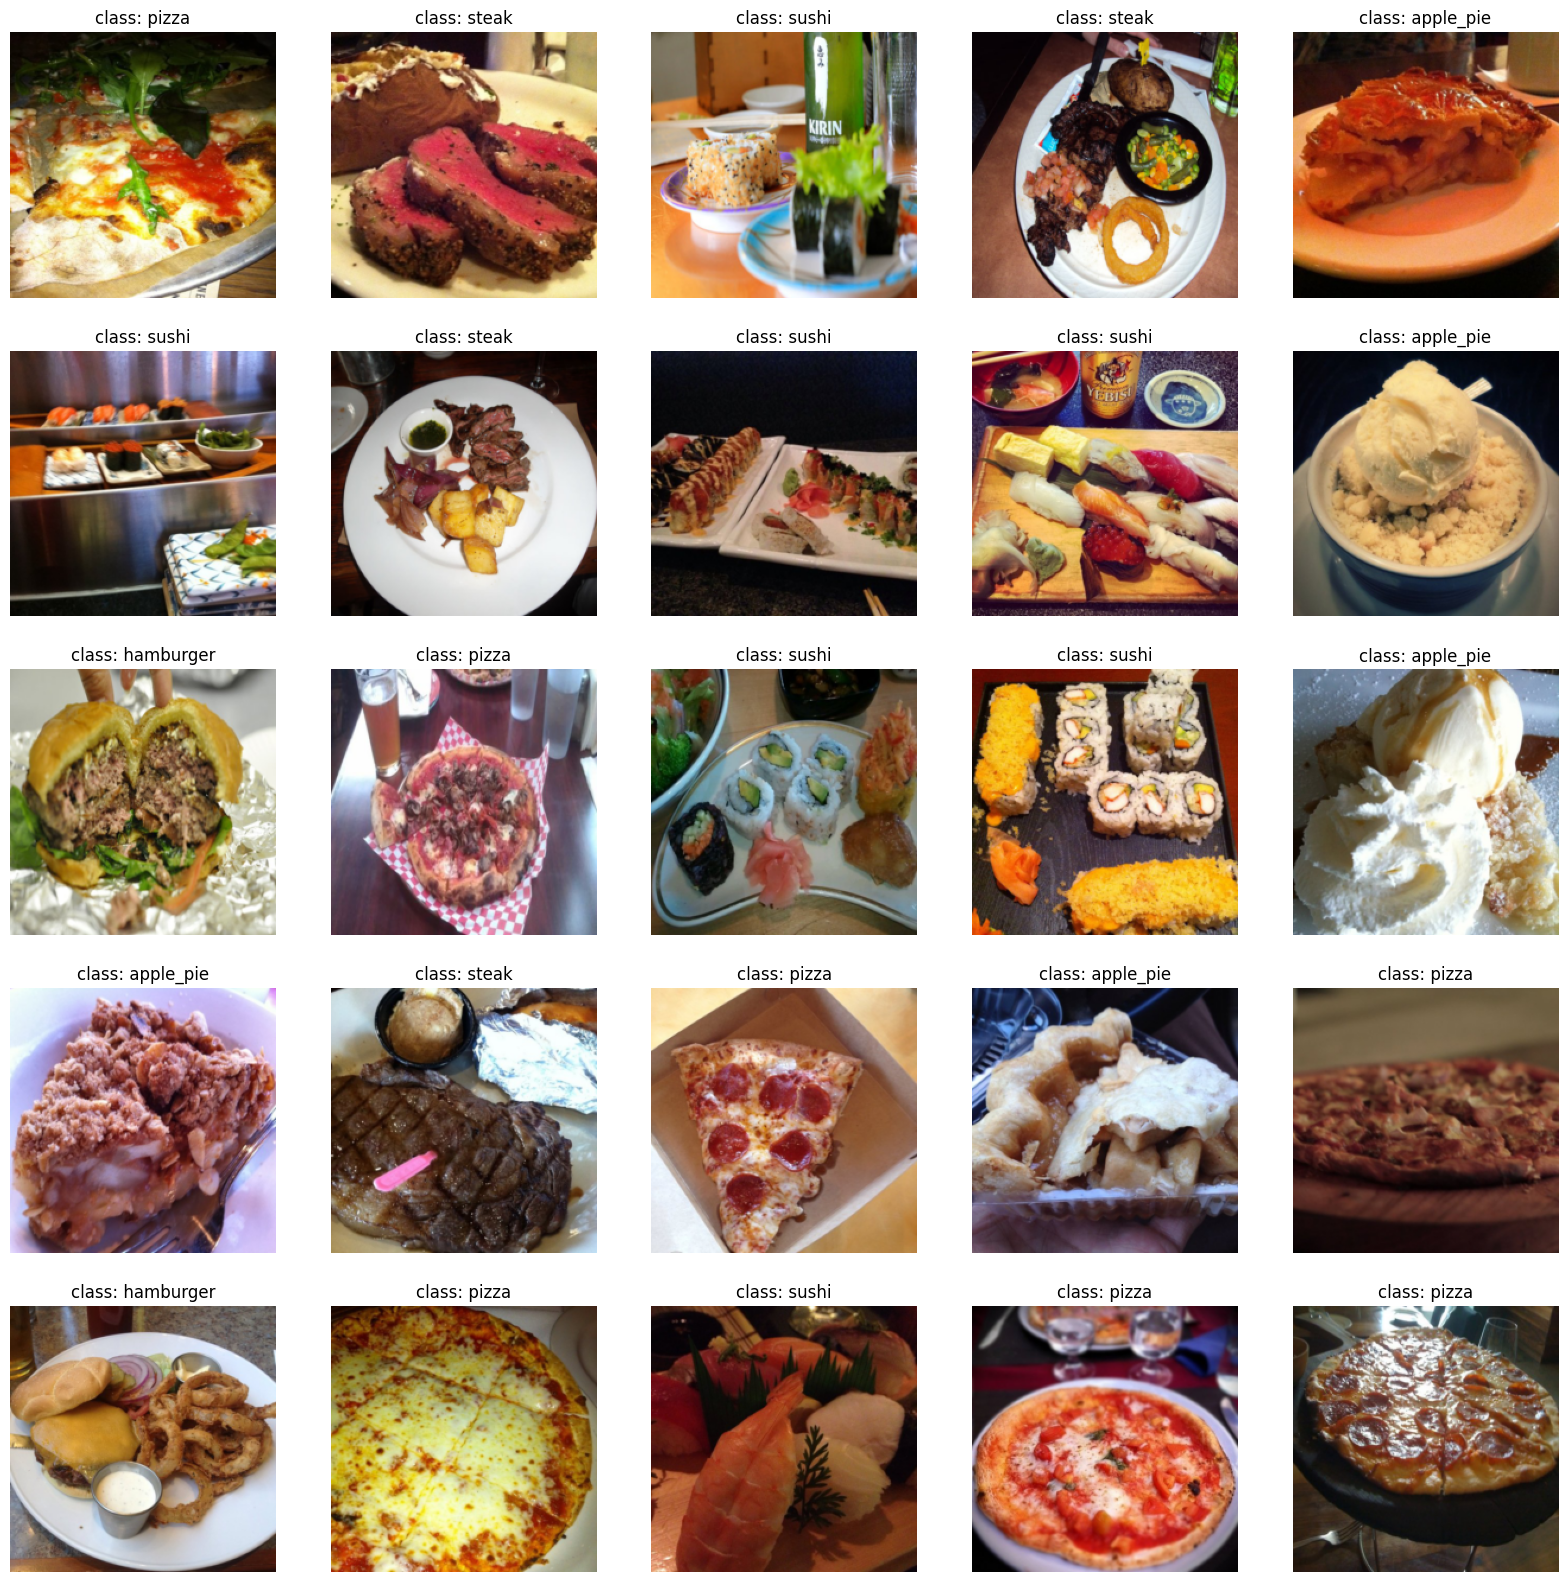

In [8]:
def display_random_images(dataset: torch.utils.data.dataset.Dataset, # or torchvision.datasets.ImageFolder?
                          classes: List[str] = None,
                          n: int = 10,
                          display_shape: bool = True,
                          rows: int = 5,
                          cols: int = 5,
                          seed: int = None):
    
   
    """Displays a number of random images from a given dataset.

    Args:
        dataset (torch.utils.data.dataset.Dataset): Dataset to select random images from.
        classes (List[str], optional): Names of the classes. Defaults to None.
        n (int, optional): Number of images to display. Defaults to 10.
        display_shape (bool, optional): Whether to display the shape of the image tensors. Defaults to True.
        rows: number of rows of the subplot
        cols: number of columns of the subplot
        seed (int, optional): The seed to set before drawing random images. Defaults to None.
    
    Usage:
    display_random_images(train_data, 
                      n=16, 
                      classes=class_names,
                      rows=4,
                      cols=4,
                      display_shape=False,
                      seed=None)
    """

    # 1. Setup the range to select images
    n = min(n, len(dataset))
    # 2. Adjust display if n too high
    if n > rows*cols:
        n = rows*cols
        #display_shape = False
        print(f"For display purposes, n shouldn't be larger than {rows*cols}, setting to {n} and removing shape display.")
    
    # 3. Set random seed
    if seed:
        random.seed(seed)

    # 4. Get random sample indexes
    random_samples_idx = random.sample(range(len(dataset)), k=n)

    # 5. Setup plot
    plt.figure(figsize=(cols*4, rows*4))

    # 6. Loop through samples and display random samples 
    for i, targ_sample in enumerate(random_samples_idx):
        targ_image, targ_label = dataset[targ_sample][0], dataset[targ_sample][1]

        # 7. Adjust image tensor shape for plotting: [color_channels, height, width] -> [color_channels, height, width]
        targ_image_adjust = targ_image.permute(1, 2, 0)

        # Plot adjusted samples
        plt.subplot(rows, cols, i+1)        
        plt.imshow(targ_image_adjust)
        plt.axis("off")
        if classes:
            title = f"class: {classes[targ_label]}"
            if display_shape:
                title = title + f"\nshape: {targ_image_adjust.shape}"
        plt.title(title)

train_data = datasets.ImageFolder(train_dir, transform=manual_transforms)
display_random_images(train_data,
                      n=25,
                      classes=class_names,
                      rows=5,
                      cols=5,
                      display_shape=False,
                      seed=None)

# 4. Training Functions

In [9]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer,
               device: torch.device = "cuda" if torch.cuda.is_available() else "cpu") -> Tuple[float, float]:
    
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()
    model.to(device)

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module, 
                        dataloader: torch.utils.data.DataLoader, 
                        loss_fn: torch.nn.Module,
                        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu") -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval() 
    model.to(device)

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

# Add writer parameter to train()
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device, 
          writer: torch.utils.tensorboard.writer.SummaryWriter # new parameter to take in a writer
          ) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Stores metrics to specified writer log_dir if present.

    Args:
      model: A PyTorch model to be trained and tested.
      train_dataloader: A DataLoader instance for the model to be trained on.
      test_dataloader: A DataLoader instance for the model to be tested on.
      optimizer: A PyTorch optimizer to help minimize the loss function.
      loss_fn: A PyTorch loss function to calculate loss on both datasets.
      epochs: An integer indicating how many epochs to train for.
      device: A target device to compute on (e.g. "cuda" or "cpu").
      writer: A SummaryWriter() instance to log model results to.

    Returns:
      A dictionary of training and testing loss as well as training and
      testing accuracy metrics. Each metric has a value in a list for 
      each epoch.
      In the form: {train_loss: [...],
                train_acc: [...],
                test_loss: [...],
                test_acc: [...]} 
      For example if training for epochs=2: 
              {train_loss: [2.0616, 1.0537],
                train_acc: [0.3945, 0.3945],
                test_loss: [1.2641, 1.5706],
                test_acc: [0.3400, 0.2973]} 
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)


        ### New: Use the writer parameter to track experiments ###
        # See if there's a writer, if so, log to it
        if writer:
            # Add results to SummaryWriter
            writer.add_scalars(main_tag="Loss", 
                               tag_scalar_dict={"train_loss": train_loss,
                                                "test_loss": test_loss},
                               global_step=epoch)
            writer.add_scalars(main_tag="Accuracy", 
                               tag_scalar_dict={"train_acc": train_acc,
                                                "test_acc": test_acc}, 
                               global_step=epoch)

            # Close the writer
            writer.close()
        else:
            pass
    ### End new ###

    # Return the filled results at the end of the epochs
    return results

# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()

def create_writer(experiment_name: str, 
                  model_name: str, 
                  extra: str=None) -> torch.utils.tensorboard.writer.SummaryWriter():
    """Creates a torch.utils.tensorboard.writer.SummaryWriter() instance saving to a specific log_dir.

    log_dir is a combination of runs/timestamp/experiment_name/model_name/extra.

    Where timestamp is the current date in YYYY-MM-DD format.

    Args:
        experiment_name (str): Name of experiment.
        model_name (str): Name of model.
        extra (str, optional): Anything extra to add to the directory. Defaults to None.

    Returns:
        torch.utils.tensorboard.writer.SummaryWriter(): Instance of a writer saving to log_dir.

    Example usage:
        # Create a writer saving to "runs/2022-06-04/data_10_percent/effnetb2/5_epochs/"
        writer = create_writer(experiment_name="data_10_percent",
                               model_name="effnetb2",
                               extra="5_epochs")
        # The above is the same as:
        writer = SummaryWriter(log_dir="runs/2022-06-04/data_10_percent/effnetb2/5_epochs/")
    """
    
    # Get timestamp of current date (all experiments on certain day live in same folder)
    timestamp = datetime.now().strftime("%Y-%m-%d") # returns current date in YYYY-MM-DD format

    if extra:
        # Create log directory path
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name, extra)
    else:
        log_dir = os.path.join("runs", timestamp, experiment_name, model_name)
        
    print(f"[INFO] Created SummaryWriter, saving to: {log_dir}...")
    return SummaryWriter(log_dir=log_dir)

# 4. Baseline Model: EfficientNet B0

## 4.1 Create and Instantiate the Model

In [10]:
# Create an EfficientNet-B0 Model
def create_effnetb0(
        transfer_learning: bool=True,
        class_names: List[str]=None,
        seed: int=SEED,
        dropout: float=0.2,
        device: torch.device = "cuda" if torch.cuda.is_available() else "cpu"
        ):
    """Creates an EfficientNetB0 feature extractor model and transforms.

    Args:
        num_classes (int, optional): number of classes in the classifier head.
            Defaults to len(class_names)
        seed (int, optional): Random seed to seed model weights. Defaults to SEED.
        dropout (float, optional): Dropout rate. Defaults to 0.2.

    Returns:
        model (torch.nn.Module): EffNetB0 feature extractor model.
        transforms (torchvision.transforms): Image transforms.
    """
    # Create EffNetB0 pretrained weights, transforms and model
    if transfer_learning:
        weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights
        
    # Load pretrained weights
    weights = torchvision.models.EfficientNet_B0_Weights.DEFAULT # .DEFAULT = best available weights 
    model = torchvision.models.efficientnet_b0(weights=weights).to(device)

    # Freeze the base parameters
    for parameter in model.parameters():
        parameter.requires_grad = not(transfer_learning)

    # Set the seeds
    set_seeds(seed)

    # Get the length of class_names (one output unit for each class)
    output_shape = len(class_names)

    # Recreate the classifier layer and seed it to the target device
    model.classifier = torch.nn.Sequential(
        torch.nn.Dropout(p=dropout, inplace=True), 
        torch.nn.Linear(in_features=1280, 
                        out_features=output_shape, # same number of output units as our number of classes
                        bias=True)).to(device)
        
    return model, weights

# Instantiate the model
effnetb0_model, effnetb0_weights = create_effnetb0(class_names=class_names)

# Print its architecture
print(effnetb0_model)

# And a summary
summary(effnetb0_model,
        input_size=(BATCH_SIZE,3,IMG_SIZE, IMG_SIZE), # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

EfficientNet(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): SiLU(inplace=True)
    )
    (1): Sequential(
      (0): MBConv(
        (block): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): SiLU(inplace=True)
          )
          (1): SqueezeExcitation(
            (avgpool): AdaptiveAvgPool2d(output_size=1)
            (fc1): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
            (fc2): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
            (activation): SiLU(inplace=True)
            (scale_activation): Sigmoid()
          )
          (2): Conv2dNormActivat

Layer (type (var_name))                                      Input Shape          Output Shape         Param #              Trainable
EfficientNet (EfficientNet)                                  [32, 3, 224, 224]    [32, 5]              --                   Partial
├─Sequential (features)                                      [32, 3, 224, 224]    [32, 1280, 7, 7]     --                   False
│    └─Conv2dNormActivation (0)                              [32, 3, 224, 224]    [32, 32, 112, 112]   --                   False
│    │    └─Conv2d (0)                                       [32, 3, 224, 224]    [32, 32, 112, 112]   (864)                False
│    │    └─BatchNorm2d (1)                                  [32, 32, 112, 112]   [32, 32, 112, 112]   (64)                 False
│    │    └─SiLU (2)                                         [32, 32, 112, 112]   [32, 32, 112, 112]   --                   --
│    └─Sequential (1)                                        [32, 32, 112, 112]   [32, 

## 4.2 Train the Model

Model name: effnetb0_lr0010_30epochs
Model path: effnetb0_lr0010_30epochs.pth
Results path: effnetb0_lr0010_30epochs.csv
[INFO] Created SummaryWriter, saving to: runs\2024-11-28\data_100_percent\effnetb0_lr0010_30epochs\30_epochs...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.9984 | train_acc: 0.6847 | test_loss: 0.5831 | test_acc: 0.8523
Epoch: 2 | train_loss: 0.6351 | train_acc: 0.8009 | test_loss: 0.4683 | test_acc: 0.8578
Epoch: 3 | train_loss: 0.5578 | train_acc: 0.8148 | test_loss: 0.4222 | test_acc: 0.8664
Epoch: 4 | train_loss: 0.5183 | train_acc: 0.8222 | test_loss: 0.3861 | test_acc: 0.8719
Epoch: 5 | train_loss: 0.4875 | train_acc: 0.8319 | test_loss: 0.3837 | test_acc: 0.8727
Epoch: 6 | train_loss: 0.4731 | train_acc: 0.8430 | test_loss: 0.3568 | test_acc: 0.8750
Epoch: 7 | train_loss: 0.4466 | train_acc: 0.8449 | test_loss: 0.3732 | test_acc: 0.8680
Epoch: 8 | train_loss: 0.4173 | train_acc: 0.8618 | test_loss: 0.3441 | test_acc: 0.8805
Epoch: 9 | train_loss: 0.4138 | train_acc: 0.8600 | test_loss: 0.3622 | test_acc: 0.8758
Epoch: 10 | train_loss: 0.4037 | train_acc: 0.8582 | test_loss: 0.3397 | test_acc: 0.8812
Epoch: 11 | train_loss: 0.4061 | train_acc: 0.8594 | test_loss: 0.3425 | test_acc: 0.8820
Epoch: 12 | train_l

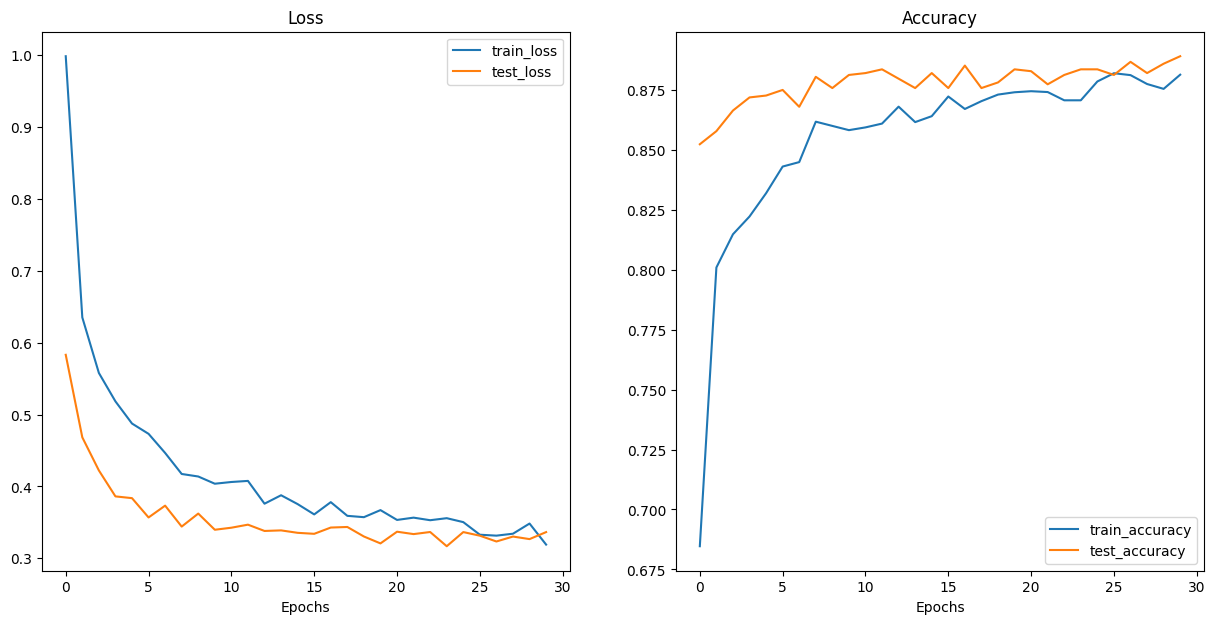

In [12]:
model_type="effnetb0"
EPOCHS = 30
LR = 0.001
model_name = f"{model_type}_lr{int(LR * 10000):04d}_{EPOCHS}epochs"
effnetb0_model_name = model_name + ".pth"
effnetb0_results_df = model_name + ".csv"

print(f"Model name: {model_name}")
print(f"Model path: {effnetb0_model_name}")
print(f"Results path: {effnetb0_results_df}")

if ENABLE['train_baseline']:
    # Create an example writer
    effnetb0_writer = create_writer(experiment_name="data_100_percent",
                                model_name=model_name,
                                extra=f"{EPOCHS}_epochs")
    
    # Create optimizer and loss function
    optimizer = torch.optim.Adam(params=effnetb0_model.parameters(),
                                lr=LR,
                                #betas=(0.9, 0.999),
                                #weight_decay=0.3) # from the ViT paper section 4.1 (Training & Fine-tuning) and Table 3 for ViT-* ImageNet-1k
    )

    loss_fn = torch.nn.CrossEntropyLoss()

    # Train the classifier
    set_seeds(SEED)
    effnetb0_results = train(model=effnetb0_model,
                             train_dataloader=train_dataloader_b0,
                             test_dataloader=test_dataloader_b0,
                             optimizer=optimizer,
                             loss_fn=loss_fn,
                             epochs=EPOCHS,
                             device=device,
                             writer=effnetb0_writer)
    
    plot_loss_curves(effnetb0_results)

In [13]:
# Save the EfficientNet B0 model
def save_model(model: torch.nn.Module,
               target_dir: str,
               model_name: str):
    """Saves a PyTorch model to a target directory.

    Args:
    model: A target PyTorch model to save.
    target_dir: A directory for saving the model to.
    model_name: A filename for the saved model. Should include
      either ".pth" or ".pt" as the file extension.

    Example usage:
    save_model(model=model_0,
               target_dir="models",
               model_name="05_going_modular_tingvgg_model.pth")
    """
    # Create target directory
    target_dir_path = Path(target_dir)
    target_dir_path.mkdir(parents=True,
                        exist_ok=True)

    # Create model save path
    assert model_name.endswith(".pth") or model_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_save_path = target_dir_path / model_name

    # Save the model state_dict()
    print(f"[INFO] Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

def load_model(model: torch.nn.Module,
               model_weights_dir: str,
               model_weights_name: str):
               #hidden_units: int):

    """Loads a PyTorch model from a target directory.

    Args:
    model: A target PyTorch model to load.
    model_weights_dir: A directory where the model is located.
    model_weights_name: The name of the model to load.
      Should include either ".pth" or ".pt" as the file extension.

    Example usage:
    model = load_model(model=model,
                       model_weights_dir="models",
                       model_weights_name="05_going_modular_tingvgg_model.pth")

    Returns:
    The loaded PyTorch model.
    """
    # Create the model directory path
    model_dir_path = Path(model_weights_dir)

    # Create the model path
    assert model_weights_name.endswith(".pth") or model_weights_name.endswith(".pt"), "model_name should end with '.pt' or '.pth'"
    model_path = model_dir_path / model_weights_name

    # Load the model
    print(f"[INFO] Loading model from: {model_path}")
    
    model.load_state_dict(torch.load(model_path, weights_only=True))
    
    return model

if ENABLE['save_baseline']:
   # Save the EfficientNet B0 model
   save_model(model=effnetb0_model,
              target_dir=model_dir,
              model_name=effnetb0_model_name)
   df_results = pd.DataFrame(effnetb0_results)
   df_results.to_csv(os.path.join(model_dir, effnetb0_results_df), index=False)  

[INFO] Saving model to: ..\models\effnetb0_lr0010_30epochs.pth


## 4.3 Training Results

In [15]:
# Instantiate the model
effnetb0_model, effnetb0_weights = create_effnetb0(class_names=class_names)

# Load the trained weights
effnetbo_model = load_model(model=effnetb0_model,
                            model_weights_dir=model_dir,
                            model_weights_name=effnetb0_model_name)

# Load the training results
effnetb0_results = pd.read_csv(os.path.join(model_dir, effnetb0_results_df))

[INFO] Loading model from: ..\models\effnetb0_lr0010_30epochs.pth


In [26]:
test_acc = effnetb0_results['test_acc'].iloc[-1]
test_los = effnetb0_results['test_loss'].iloc[-1]
model_size = Path(os.path.join(model_dir, effnetb0_model_name)).stat().st_size // (1024*1024)
print(f"Accuracy on the test set: {test_acc}")
print(f"Loss on the test set: {test_los}")
print(f"Model size: {model_size} MB")

Accuracy on the test set: 0.8890625
Loss on the test set: 0.3364427103661001
Model size: 15 MB
